## ✒️   Code Modules & Settings

In [1]:
import warnings; warnings.filterwarnings('ignore')
import os,h5py,urllib,torch,pandas as pd,numpy as np
from sklearn.ensemble import RandomForestClassifier as sRFC
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.metrics import classification_report
import tensorflow as tf,tensorflow_hub as th
import sympy as sp,pylab as pl
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf,torch.nn as tnn
dev=torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu')
tmodel=models.vgg16(pretrained=True,progress=False)
from IPython.core.magic import register_line_magic

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


## ✒️ Data Loading

In [2]:
file_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
file_name='TomatoCultivars160.h5'
img_size=160
def get_file(file_path,file_name):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
get_file(file_path,file_name)
with h5py.File(file_name,'r') as f:
    keys=list(f.keys())
    sp.pretty_print('file keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    labels=np.array(f[keys[1]])
    names=[el.decode('utf-8') for el in f[keys[2]]]
    f.close()

file keys: images, labels, names


## ✒️ Data Processing

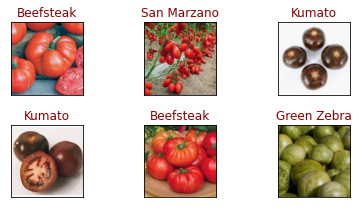

,train,valid,test
image shape,"(622, 160, 160, 3)","(77, 160, 160, 3)","(77, 160, 160, 3)"
image type,float32,float32,float32
label shape,"(622,)","(77,)","(77,)"
label type,int32,int32,int32


In [3]:
N=labels.shape[0]; n=int(.1*N)
num_classes=len(names); start=100 
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type',
           'label shape','label type'])
def display_imgs(images,labels,names,start):
    fig=pl.figure(figsize=(6,3))
    n=np.random.randint(0,start-1)
    for i in range(n,n+6):
        ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
        ax.set_title(
            names[labels[i]],color='darkred',
            fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names,start)
display(df)

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
batch_size2=16; img_size2=64
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=np.transpose(x_train,(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=np.transpose(x_valid,(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=np.transpose(x_test,(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,
                         batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,
                         batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,
                        batch_size=batch_size2)}
del train2,valid2,test2

0.4377849 0.29313976


image dimensions: torch.Size([16, 3, 160, 160])
label dimensions: torch.Size([16])


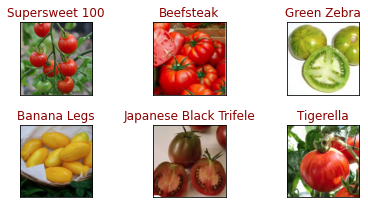

In [5]:
@register_line_magic
def display_data_imgs(data):
    global names
    for images,labels in dataloaders[data]:  
        sp.pretty_print(
            'image dimensions: %s'%str(images.shape))
        sp.pretty_print(
            'label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,names,10)
        break
%display_data_imgs valid

## ✒️ Sklearn

In [6]:
def classifier_fit_score(classifier,x_train,x_test,y_train,y_test):
    classifier.fit(x_train,y_train)     
    y_clf_train=classifier.predict(x_train)
    y_clf_test=classifier.predict(x_test)        
    acc_clf_train=round(accuracy_score(y_train,y_clf_train),4)
    acc_clf_test=round(accuracy_score(y_test,y_clf_test),4)
    loss_clf_train=round(hamming_loss(y_train,y_clf_train),4)
    loss_clf_test=round(hamming_loss(y_test,y_clf_test),4)  
    return [y_clf_train,y_clf_test,
            acc_clf_train,acc_clf_test,
            loss_clf_train,loss_clf_test]
[y_srfc_train,y_srfc_test,acc_srfc_train,
 acc_srfc_test,loss_srfc_train,loss_srfc_test]=\
classifier_fit_score(
    sRFC(),x_train.reshape(-1,3*img_size**2),
    x_test.reshape(-1,3*img_size**2),y_train,y_test)
sp.pretty_print(classification_report(y_test,y_srfc_test))

              precision    recall  f1-score   support
                                                     
           0       0.75      0.60      0.67         5
           1       0.56      0.62      0.59         8
           2       0.18      0.67      0.29         3
           3       0.40      0.40      0.40         5
           4       0.33      0.50      0.40         2
           5       0.30      0.33      0.32         9
           6       0.00      0.00      0.00         6
           7       0.40      0.67      0.50         6
           8       0.33      0.17      0.22         6
           9       0.00      0.00      0.00         4
          10       0.20      0.50      0.29         2
          11       0.75      0.43      0.55         7
          12       0.00      0.00      0.00         3
          13       0.75      0.60      0.67         5
          14       0.00      0.00      0.00         6
                                                     
    accuracy                

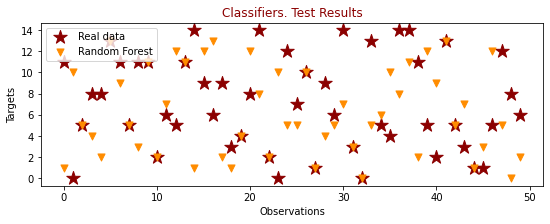

In [7]:
def plot_predict(y_predict,label_predict,t=50,fig_size=9):
    pl.figure(figsize=(fig_size,fig_size//3)); x=range(t)
    pl.scatter(x,y_test[:t],marker='*',s=200,
               color='darkred',label='Real data')
    pl.scatter(x,y_predict[:t],marker='v',
               s=50,color='darkorange',label=label_predict)
    pl.xlabel('Observations'); pl.ylabel('Targets') 
    pl.title('Classifiers. Test Results',color='darkred',
             fontdict={'fontsize':'large'})
    pl.legend(loc=2,fontsize=10)
    pl.tight_layout; pl.show()
plot_predict(y_srfc_test,'Random Forest')

## ✒️ Keras

In [8]:
def kmodel(leaky_alpha,num_classes,img_size):
    model=tf.keras.Sequential()
    model.add(tkl.Conv2D(
        32,(7,7),padding='same', 
        input_shape=(img_size,img_size,3)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(96,(7,7)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(512))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(.5))    
    model.add(tkl.Dense(num_classes))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(.005,num_classes,img_size)

In [9]:
fw='/tmp/checkpoint'
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=2,save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=5,verbose=2,factor=.8)
history=kmodel.fit(
    x_train,y_train,epochs=70,batch_size=16,verbose=2,
    validation_data=(x_valid,y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/70
39/39 - 51s - loss: 2.6225 - accuracy: 0.1270 - val_loss: 2.3822 - val_accuracy: 0.2987

Epoch 00001: val_accuracy improved from -inf to 0.29870, saving model to /tmp/checkpoint
Epoch 2/70
39/39 - 48s - loss: 2.1952 - accuracy: 0.2170 - val_loss: 2.1158 - val_accuracy: 0.2597

Epoch 00002: val_accuracy did not improve from 0.29870
Epoch 3/70
39/39 - 49s - loss: 1.9554 - accuracy: 0.2717 - val_loss: 1.8296 - val_accuracy: 0.2857

Epoch 00003: val_accuracy did not improve from 0.29870
Epoch 4/70
39/39 - 49s - loss: 1.9161 - accuracy: 0.2830 - val_loss: 1.9319 - val_accuracy: 0.3117

Epoch 00004: val_accuracy improved from 0.29870 to 0.31169, saving model to /tmp/checkpoint
Epoch 5/70
39/39 - 48s - loss: 1.8051 - accuracy: 0.3280 - val_loss: 1.8173 - val_accuracy: 0.3377

Epoch 00005: val_accuracy improved from 0.31169 to 0.33766, saving model to /tmp/checkpoint
Epoch 6/70
39/39 - 48s - loss: 1.7024 - accuracy: 0.3698 - val_loss: 1.7876 - val_accuracy: 0.3766

Epoch 00006: val_

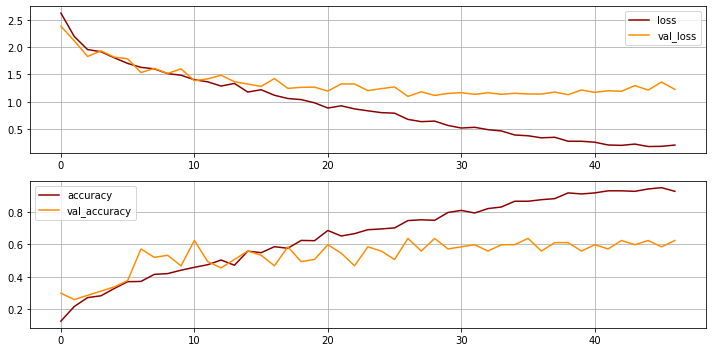

In [10]:
def keras_history_plot(
    fit_history,fig_size=10,color='darkorange'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size//2))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[0,2]].plot(
        ax=ax1,color=['darkred',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[1,3]].plot(
        ax=ax2,color=['darkred',color],grid=True)
    pl.tight_layout(); pl.show()
keras_history_plot(history)

[1.4286776781082153, 0.44155845046043396]


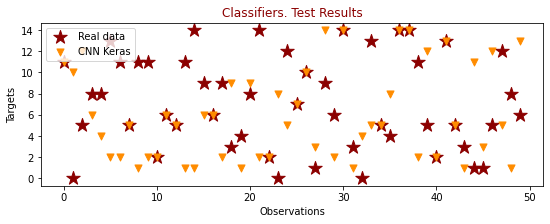

In [11]:
kmodel.load_weights(fw)
sp.pretty_print(
    kmodel.evaluate(x_test,y_test,verbose=0))
y_cnn_test=np.argmax(kmodel.predict(x_test),axis=-1)
plot_predict(y_cnn_test,'CNN Keras')
del kmodel,x_train,x_valid,x_test

## ✒️ PyTorch

In [12]:
for param in tmodel.parameters(): 
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
print('\n\n',tmodel)



 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [13]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    st1='epoch: %03d/%03d || batch: %03d/%03d || cost: %.4f'
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                sp.pretty_print(
                    st1%(epoch+1,epochs,batch_ids,
                    len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            sp.pretty_print('epoch: %03d/%03d'%(epoch+1,epochs))
            sp.pretty_print(
                'valid acc/loss: %.2f%%/%.2f'%\
                (model_acc(tmodel,dataloaders['valid']),
                 epoch_loss(tmodel,dataloaders['valid'])))

In [14]:
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())
%train_run 10

epoch: 001/010 || batch: 000/038 || cost: 2.7289
epoch: 001/010 || batch: 010/038 || cost: 2.1224
epoch: 001/010 || batch: 020/038 || cost: 1.6432
epoch: 001/010 || batch: 030/038 || cost: 1.4684
epoch: 001/010
valid acc/loss: 50.00%/1.27
epoch: 002/010 || batch: 000/038 || cost: 1.4609
epoch: 002/010 || batch: 010/038 || cost: 1.1706
epoch: 002/010 || batch: 020/038 || cost: 0.9445
epoch: 002/010 || batch: 030/038 || cost: 0.7989
epoch: 002/010
valid acc/loss: 71.88%/0.91
epoch: 003/010 || batch: 000/038 || cost: 0.7131
epoch: 003/010 || batch: 010/038 || cost: 0.8802
epoch: 003/010 || batch: 020/038 || cost: 1.1194
epoch: 003/010 || batch: 030/038 || cost: 0.8483
epoch: 003/010
valid acc/loss: 64.06%/0.97
epoch: 004/010 || batch: 000/038 || cost: 1.1483
epoch: 004/010 || batch: 010/038 || cost: 0.4753
epoch: 004/010 || batch: 020/038 || cost: 0.5006
epoch: 004/010 || batch: 030/038 || cost: 0.9180
epoch: 004/010
valid acc/loss: 70.31%/0.82
epoch: 005/010 || batch: 000/038 || cost: 0.

In [15]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('test acc: %.2f%%'%\
          model_acc(tmodel,dataloaders['test']))

test acc: 78.12%
